In [1027]:
# ID3 Decision Tree Classification on Titanic Dataset
# https://www.kaggle.com/datasets/yasserh/titanic-dataset/data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

# Load the dataset
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1028]:
print(data.info()) # shows columns names, number of non-null values and data type
print(data.isnull().sum()) # shows number of null values in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6

# Feature Selection/Creation

Handled feature creation/selection first because 'Age' column will be filled based on 'Title'(to be created) column .

### Why?
Because I can use the passenger's title appeared in 'Name' column to determin the missing age better than randomly filling it with median of the whole column and no the median of the title itself.

In [1029]:
df = data.copy()

In [1030]:
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+\.)', expand=False)
df['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.'], dtype=object)

In [1031]:
df['Title'] = df['Title'].replace(['Sir.'], 'Mr.')
df['Title'] = df['Title'].replace(['Mme.', 'Lady.', 'Countess.'], 'Mrs.')
df['Title'] = df['Title'].replace(['Ms.', 'Mlle.'], 'Miss.')
df['Title'] = df['Title'].replace(['Dr.', 'Rev.', 'Major.', 'Col.', 'Capt.', 'Jonkheer.', 'Don.'], 'Rare')
df['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Rare'], dtype=object)

In [1032]:
df.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'] , axis=1, inplace=True) # Malo4 lazma + most of it is null

In [1033]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr.
1,1,1,female,38.0,1,0,71.2833,C,Mrs.
2,1,3,female,26.0,0,0,7.9250,S,Miss.
3,1,1,female,35.0,1,0,53.1000,S,Mrs.
4,0,3,male,35.0,0,0,8.0500,S,Mr.


# Handle Missing Values


In [1034]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2
Title,0


In [1035]:
df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median')) # cus mean is sensitive to outliers.

imputer_embarked = SimpleImputer(strategy='most_frequent')
df[['Embarked']] = imputer_embarked.fit_transform(df[['Embarked']])

df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0
Title,0


# Encoding


Based on the unique values, I'll choose the encoding method.



In [1036]:
for col in df.select_dtypes(include='object').columns:
    print(f"'{col}': {df[col].unique()}")

'Sex': ['male' 'female']
'Embarked': ['S' 'C' 'Q']
'Title': ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Rare']


Binary mapping for 'Sex' column.

In [1037]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

One-hot Encoding

In [1038]:
df = pd.get_dummies(df, columns=['Title', 'Embarked'], drop_first=True)

In [1039]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,False,True,False,False,False,True
1,1,1,1,38.0,1,0,71.2833,False,False,True,False,False,False
2,1,3,1,26.0,0,0,7.9250,True,False,False,False,False,True
3,1,1,1,35.0,1,0,53.1000,False,False,True,False,False,True
4,0,3,0,35.0,0,0,8.0500,False,True,False,False,False,True


# Spliting



In [1040]:
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(y.unique())

Training set size: (712, 12)
Testing set size: (179, 12)
[0 1]


# Scaling


In [1041]:
sc = StandardScaler()
cols_to_scale = ['Age', 'Fare']

X_train[cols_to_scale] = sc.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = sc.transform(X_test[cols_to_scale])

In [1042]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Embarked_Q,Embarked_S
692,3,0,0.036020,0,0,0.513812,False,True,False,False,False,True
481,2,0,0.036020,0,0,-0.662563,False,True,False,False,False,True
527,1,0,0.036020,0,0,3.955399,False,True,False,False,False,True
855,3,1,-0.868936,0,1,-0.467874,False,False,True,False,False,True
801,2,1,0.111433,1,1,-0.115977,False,False,True,False,False,True


# OVER SAMPLING

In [1043]:
print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))

273
439
439
439


# Training

## DT

In [1044]:
DT_model = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=5
)
DT_model.fit(X_train, y_train)

# Prediction
DT_y_pred = DT_model.predict(X_test)
DT_y_pred_proba = DT_model.predict_proba(X_test)

## KNN

In [1045]:
k = 10
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

KNN_y_pred = knn_model.predict(X_test)
KNN_y_pred_proba = knn_model.predict_proba(X_test)

### Actual vs Predicted comparison


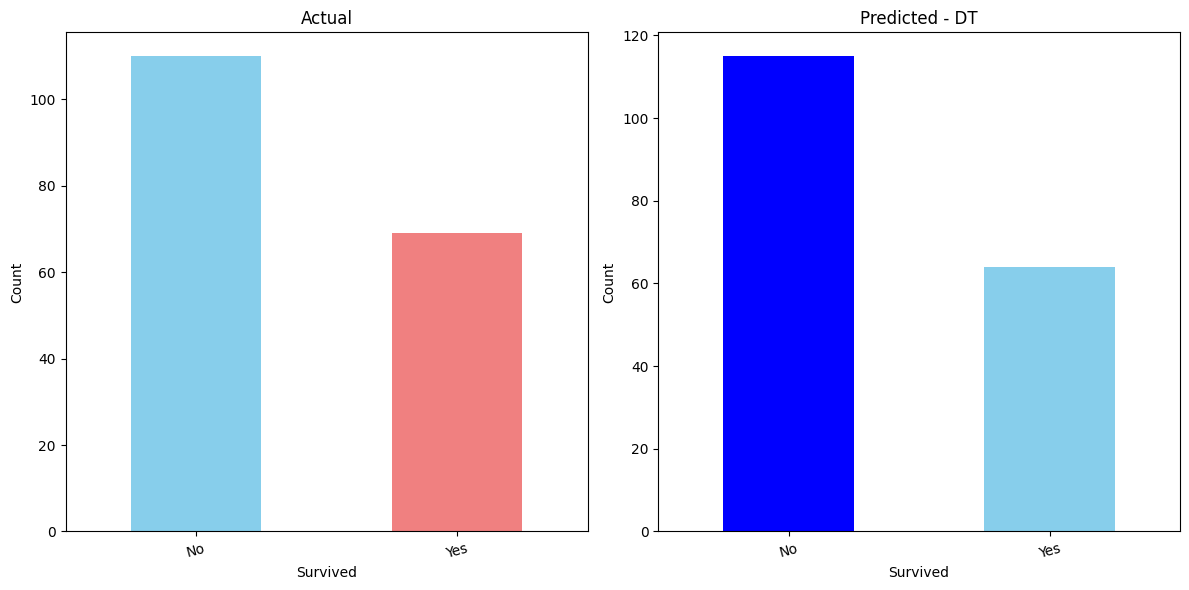

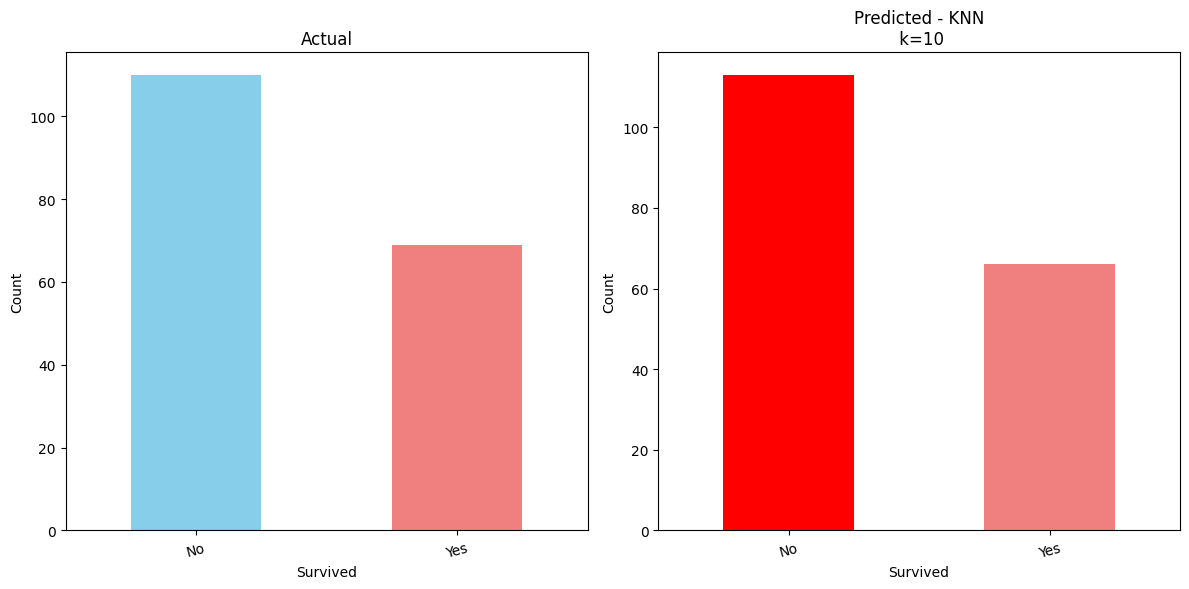

In [1046]:
# =================================DT========================================
DT_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': DT_y_pred,
    'Correct': y_test.values == DT_y_pred
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
DT_comparison_df['Actual'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Actual')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=15)

plt.subplot(1, 2, 2)
DT_comparison_df['Predicted'].value_counts().plot(kind='bar', color=['blue', 'skyblue'])
plt.title('Predicted - DT')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=15)

plt.tight_layout()
plt.show()

# =================================KNN========================================
KNN_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': KNN_y_pred,
    'Correct': y_test.values == KNN_y_pred
})

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
KNN_comparison_df['Actual'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Actual')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=15)

plt.subplot(1, 2, 2)
KNN_comparison_df['Predicted'].value_counts().plot(kind='bar', color=['red', 'lightcoral'])
plt.title(f'Predicted - KNN\n k={k}')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'], rotation=15)

plt.tight_layout()
plt.show()

## Accuracy

In [1047]:
DT_acc = accuracy_score(y_test, DT_y_pred)
print(f"DT Accuracy: {DT_acc * 100:.2f}%")
print("-" * 30)
print(classification_report(y_test, DT_y_pred, target_names=['Did Not Survive', 'Survived']))

print("=" * 60)

KNN_acc = accuracy_score(y_test, KNN_y_pred)
print(f"KNN Accuracy: {KNN_acc * 100:.2f}%")
print("-" * 30)
print(classification_report(y_test, KNN_y_pred, target_names=['Did Not Survive', 'Survived']))

DT Accuracy: 84.92%
------------------------------
                 precision    recall  f1-score   support

Did Not Survive       0.86      0.90      0.88       110
       Survived       0.83      0.77      0.80        69

       accuracy                           0.85       179
      macro avg       0.84      0.83      0.84       179
   weighted avg       0.85      0.85      0.85       179

KNN Accuracy: 84.92%
------------------------------
                 precision    recall  f1-score   support

Did Not Survive       0.87      0.89      0.88       110
       Survived       0.82      0.78      0.80        69

       accuracy                           0.85       179
      macro avg       0.84      0.84      0.84       179
   weighted avg       0.85      0.85      0.85       179



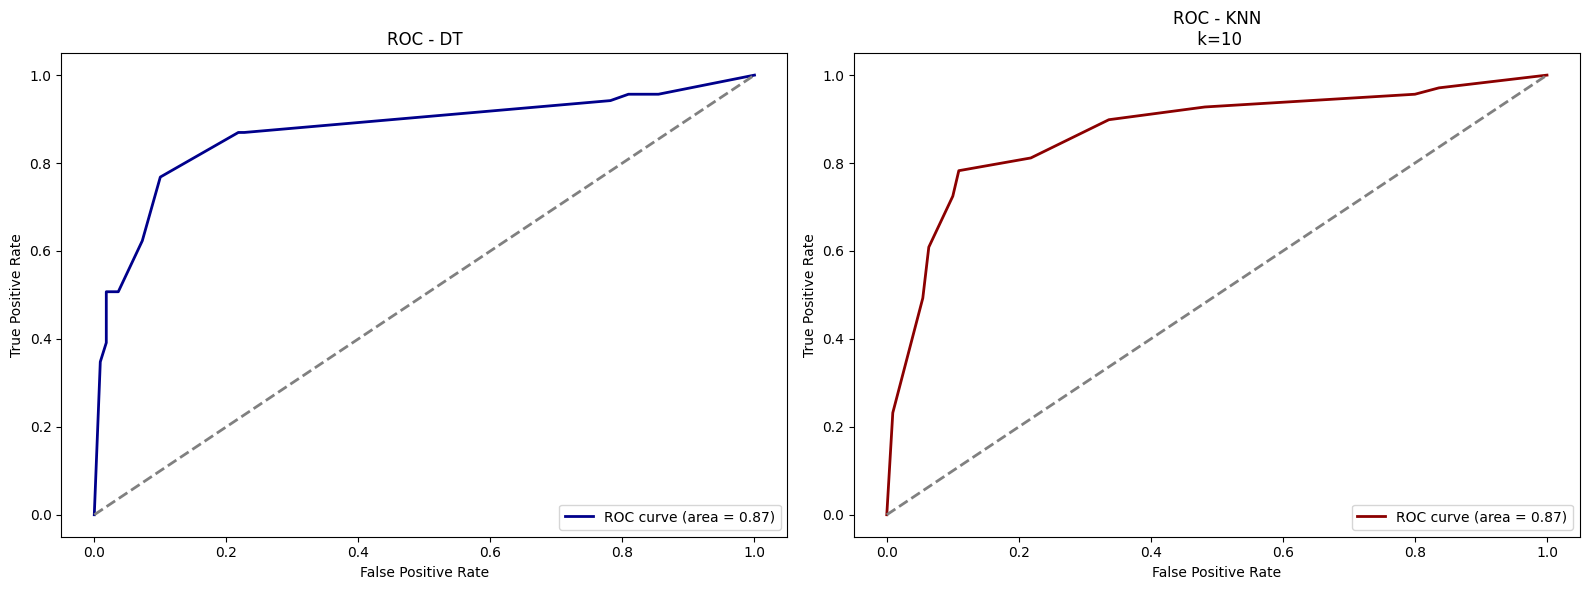

In [1048]:
# Receiver Operating Characteristic curve

# ==============DT===============

plt.figure(figsize=(16, 6))

dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, DT_y_pred_proba[:, 1])
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.subplot(1, 2, 1)
plt.plot(dt_fpr, dt_tpr, color='darkblue', lw=2, label=f'ROC curve (area = {dt_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - DT')
plt.legend(loc="lower right")


# ==============KNN===============

knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, KNN_y_pred_proba[:, 1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

plt.subplot(1, 2, 2)
plt.plot(knn_fpr, knn_tpr, color='darkred', lw=2, label=f'ROC curve (area = {knn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - KNN\n k={k}')
plt.legend(loc="lower right")


plt.tight_layout()
plt.show()

### Confusion Matrix


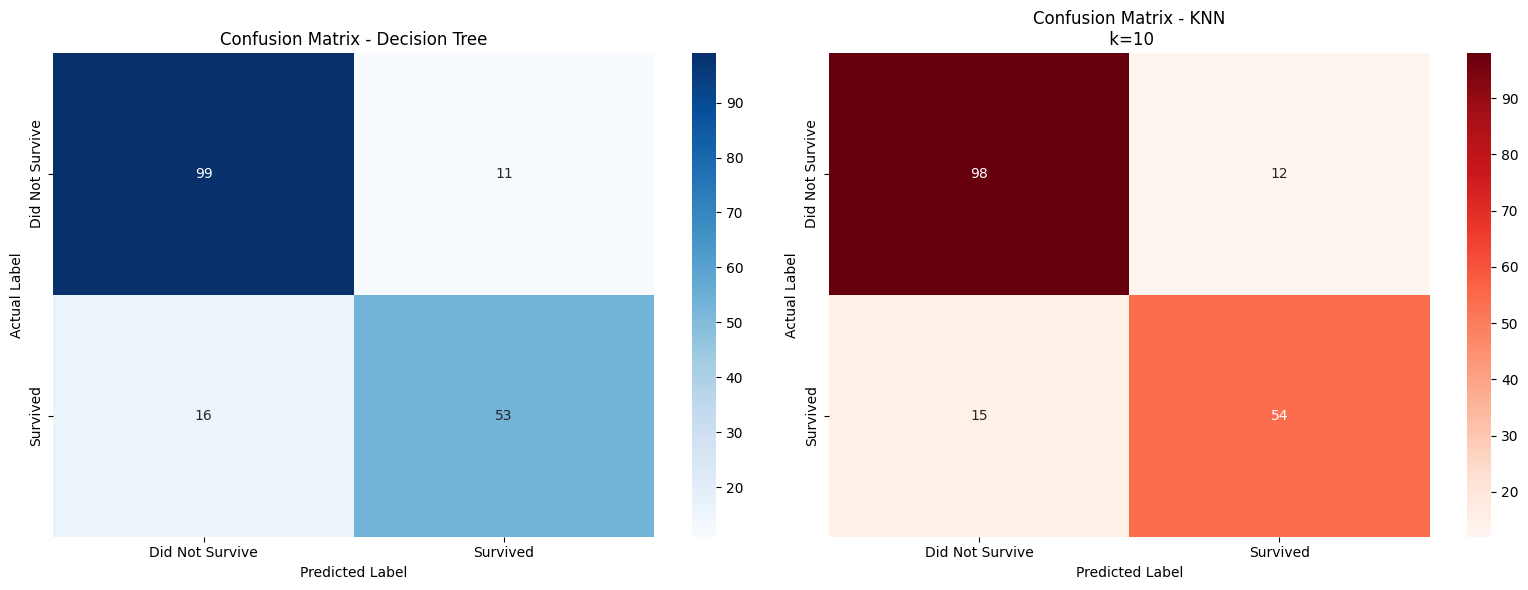

In [1049]:
plt.figure(figsize=(16, 6))

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, DT_y_pred)
plt.subplot(1, 2, 1)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, KNN_y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.title(f'Confusion Matrix - KNN\n k={k}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')


plt.tight_layout()
plt.show()